# Convolutional Neural Networks

Presentamos el concepto de convolución, kernel y su aplicación a las redes neuronales convolucionales con un ejemplo de clasificación de imágenes.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
from sklearn.manifold import TSNE
from scipy.ndimage import rotate
import numpy as np

Definimos una función para poder visualizar imagenes:

In [2]:
def plot_images(images, num=2):
    """Visualización de imagenes"""
    _, axes = plt.subplots(nrows=1, ncols=num, figsize=(10, 3))
    for ax, image in zip(axes, images):
        #ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

#### Ejemplo de funcionamiento de convoluciones

Las convoluciones se aplican sobre imágene para poder preservar características que sean invariantes ante traslaciones. Empezaremos con un ejemplo simple, una imagen con valores binarios -1 y 1 que forman una X.

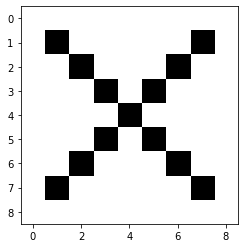

In [3]:
#Definimos imágen de X
img_x = np.array([[-1,-1,-1,-1,-1,-1,-1,-1, -1],[-1, 1,-1,-1,-1,-1, -1, 1, -1],[-1,-1, 1,-1,-1, -1, 1, -1, -1],
                [-1,-1,-1, 1, -1, 1,-1,-1, -1],[-1,-1, -1,-1, 1, -1,-1,-1, -1],[-1, -1,-1, 1,-1, 1, -1,-1, -1],
                [-1,-1, 1,-1,-1,-1, 1,-1, -1],[-1, 1,-1,-1,-1,-1,-1, 1, -1], [-1, -1,-1,-1,-1,-1,-1, -1, -1]])

plt.imshow(img_x, cmap='Greys')
plt.show()

## Translaciones

Una traslación desplaza una imagen en una dirección determinada por un vector $t = (t_1, t_2)$. En una imagen, lo que esto hace es desplazar cada pixel de ésta en esta dirección de tal forma que la imagen resultante se haya movido, trasladado, hacia la dirección indicada por el vector $t$.

Definimos una función de traslación que nos permitirá mover la imagen en una dirección indicada, alterando la forma en que la red neuronal percibe esta imagen.

In [4]:
def translate(image, t=(1,1)):
    """Función de translación de la imagen"""
    tx,ty = t
    N,M = image.shape
    image_translated = -np.ones_like(image)
    image_translated[max(tx,0):M+min(tx,0), max(ty,0):N+min(ty,0)]=image[-min(tx,0):M-max(tx,0),-min(ty,0):N-max(ty,0)]  
    
    return image_translated

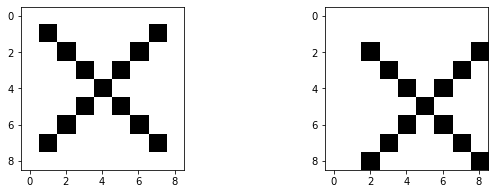

In [5]:
#Aplicamos la traslación
tr_img = translate(img_x, t=(1, 1))

plot_images([img_x, tr_img])
plt.show()

## Filtros

Los filtros o kernels nos permitirán capturar ciertas invarianzas en las imágenes. Aquí definimos tres kernels que se relacionan con la estructura de la figura X. Veremos que al convolucionar con la imagen se preserva la información de estas estructuras.

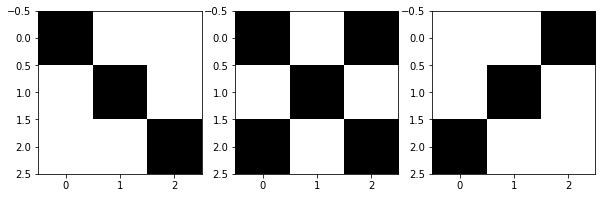

In [6]:
#Información de la diagonal
diag1 = np.array([[1,-1,-1],[-1,1,-1],[-1,-1,1]])
#Información del centro de la imagen
cent = np.array([[1,-1,1],[-1,1,-1],[1,-1,1]])
#Inofrmación de la diagonal contraria
diag2 = np.array([[-1,-1,1],[-1,1,-1],[1,-1,-1]])

plot_images([diag1, cent, diag2], num=3)
plt.show()

## Convolución

Dada la imagen y un kernel podemos aplicar una convolución (más precisamente una correlación cruzada) entre ambas para obtener de la imagen la información que proporciona el kernel. Para "medir" la imagen en relación al kernel.

La función de convolución de las redes convolucionales se definirá como:

$$\big(W*x\big)_{i,j} = \sum_{m=0}^{k-1} \sum_{n=0}^{k'-1} W_{i,j} x_{i+m,j+n} + b_j$$

Donde el kernel $W$ es una matriz de $k\times k'$ y la imagen $x$ tiene altura $H$ y anchura $W$. Además, podremos hablar del número de canales $C$, que en este caso es de 1, pero en general es de 3 o 4, pues se cuenta con RGB o RGB-$\alpha$.

In [7]:
def calculate_target_size(img_size, kernel_size):
    """
    Función que calcula las dimensiones de 
    la imagen resultante de la convolución
    """
    num_pixels = 0
    for i in range(img_size):
        #i + tamaño de kernel
        added = i + kernel_size
        #Debe ser menor al tamaño de la imagen
        if added <= img_size:
            #Incrementa en 1
            num_pixels += 1
            
    return num_pixels

def convolve(img, kernel):
    """Función de convolución (cross correlation)"""
    #Obtieene el tamaño del target, la imagen que resultará de la convolución
    tgt_size = calculate_target_size(img.shape[0], kernel.shape[0])
    #Tamaño del kernel
    k = kernel.shape[0]
    
    #Inicializa la convolución con 0s
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    for i in range(tgt_size):
        for j in range(tgt_size):
            #Vecinos de un pixel con respecto al tamaño del kernel
            neigs = img[i:i+k, j:j+k]            
            # Aplica la convolución
            convolved_img[i, j] = np.sum(neigs*kernel)
            
    return convolved_img

#### Convolución sobre la imagen original

El resultado de aplicar cada uno de los filtros sobre la imagen original es la siguiente. Debe notarse que es común aplicar una capa ReLU a la convolución, aunque puede aplicarse cualquier otra función de activación:

In [8]:
#Función relu
ReLU = lambda x: np.array([np.max([0,c]) for c in x.reshape(x.shape[0]*x.shape[1])]).reshape(x.shape[0],x.shape[1])

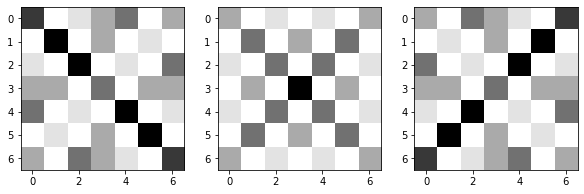

In [9]:
diag1_conv_x = ReLU( convolve(img_x, diag1) )
diag2_conv_x = ReLU( convolve(img_x, diag2) )
cent_conv_x = ReLU( convolve(img_x, cent) )

plot_images([diag1_conv_x, cent_conv_x, diag2_conv_x], num=3)

#### Convolución sobre imagen transladada

Si aplicamos las convoluciones con los kernels en la imagen trasladada obtendrémos como resultado imágenes en las que esta traslación se preserva; es decir, es equivariante.

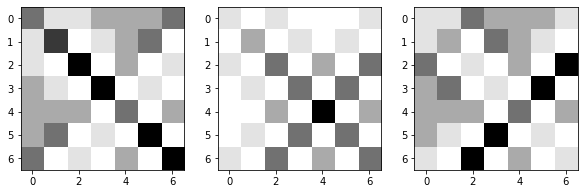

In [10]:
diag1_conv_Tx = ReLU( convolve(tr_img, diag1) )
diag2_conv_Tx = ReLU( convolve(tr_img, diag2) )
cent_conv_Tx = ReLU( convolve(tr_img, cent) )

plot_images([diag1_conv_Tx, cent_conv_Tx, diag2_conv_Tx], num=3)

### Max pooling

La función de Pooling toma el resultado de la convolución y regresa una representación $h$ de los datos que buscar ser invariante. Se suelen utilizar la función de averag pooling y max pooling. Aquí usamos max pooling que se define como:

$$h = \arg\max \big\{(W*x)_{i+c,j+c}\big\}$$

Donde $c$ es el tamaño de la ventana del pooling. El pooling se puede visualzde la siguiente manera:

![maxpool](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

Es decir, se toman los valores máximos en una ventana cuadrada por cada sección de la imagen. La matriz resultante generalmente es aplanada (convertida en un vector) para que pase por una red Feedforward.

In [11]:
def max_pooling(img, size=(2,2)):
    """Max pooling"""
    M, N = img.shape
    K, L = size
    MK = M // K
    NL = N // L
    
    return img[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))

Aquí vemos el max poolin para los diferentes kernels en la imagen original y la imagen trasladada:

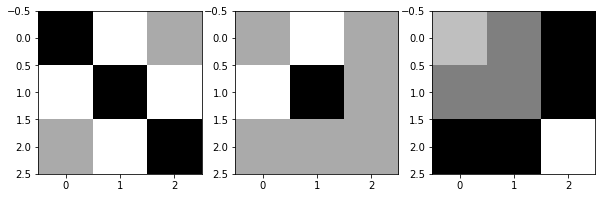

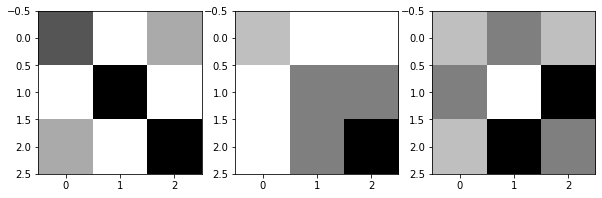

In [12]:
#Max pooling sobre imagen original
pool_x_d1 = max_pooling(diag1_conv_x)
pool_x_d2 = max_pooling(diag2_conv_x)
pool_x_c = max_pooling(cent_conv_x)
#Max pooling sobre imagen trasladada
pool_Tx_d1 = max_pooling(diag1_conv_Tx)
pool_Tx_d2 = max_pooling(diag2_conv_Tx)
pool_Tx_c = max_pooling(cent_conv_Tx)

plot_images([pool_x_d1, pool_x_c, pool_x_d2], num=3)
plot_images([pool_Tx_d1, pool_Tx_c, pool_Tx_d2], num=3)

## Ejemplo en imágenes más complejas

Podemos tomar imágenes más complejas en donde el número de canales sea RGB. Ante esto deberemos también tomar kernels más complejos:

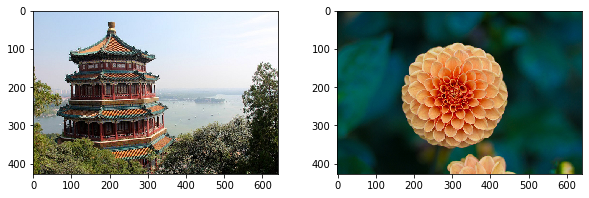

In [13]:
#Imágene muestra
images = load_sample_images()        
plot_images(images.images)

##  Otros kernels comúnes

Existen diferentes formar de tratar un kernel. Aquí definimos tres kernels, como se ve, en la mayoría de estos el pixel central está determinado en el centro (en donde es mayor el peso), los otros se ponderán con relación a este pixel en diferentes relaciones de vecinos.

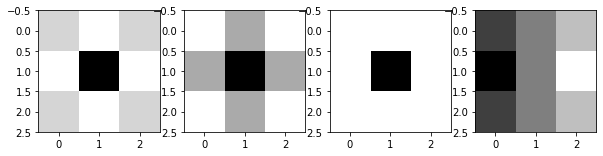

In [14]:
#Filtro sharpen
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

#Filtro Blur
blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

#Filtro outline
outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

#Filtro convolución
conv = np.array([
    [1, 0, -1],
    [2,  0, -2],
    [1, 0, -1]
])

plot_images([sharpen, blur, outline, conv], num=4)

Podemos ver qué es lo que hace uno de estos kernels con respecto a la imagen:

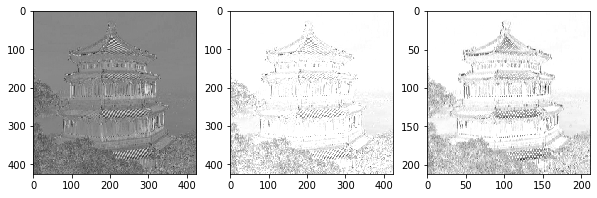

In [15]:
#Convolución con kernel
img_conv = convolve(images.images[0], outline)
#Aplicando ReLU
x = ReLU(img_conv)
#Aplicando max pool
h = max_pooling(x, size=(2,2))

plot_images([img_conv, x, h], num=3)

# Redes convolucionales

Entendido lo que hacen los kernels y las convoluciones, podemos aplicarlos para aprender redes neuronales que puedan manejar diferentes transformaciones en las imágenes. Trabajaremos con el dataset MNIST para clasificar digitos.

In [16]:
import torch
import torch.nn as nn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

### Preparación del dataset

Cargamos el dataset y obtenemos el conjunto de entrenamiento y evaluación:

In [17]:
#Cargar dataset
x = load_digits().images
y = load_digits().target
#Núm de clases:
n = len(set(y))

#Separar datasets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)
#Dimensiones de dataset
N, H, W = x_train.shape

### Comparación con Feedforward

Las redes Feedforward se ven limitadas al tratar con imágenes, pues no son sensibles a las traslaciones. Para comparar el desempeño de las redes convolucionales, podemos ver en primer lugar cómo maneja estos datos una red Feedforward, esperando que las redes convolucionales mejoren su desempeño.

In [18]:
#Definimos la red feedforward
ffw = nn.Sequential(nn.Linear(H*W, 128), nn.ReLU(), nn.Linear(128, 254), nn.Tanh(), 
                    nn.Linear(254, n), nn.Softmax(1))

#De matriz de imagen a vector
x_simple = torch.Tensor(x_train.reshape(N, H*W))

#Entrenamiento
optimizer = torch.optim.Adam(ffw.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1000
for t in tqdm(range(epochs)):
    prob = ffw(x_simple)
    loss = criterion(input=prob, target=torch.tensor(y_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:03<00:00, 253.48it/s]


#### Evaluación de la Feedforward

Como se ve, los resultados con la red Feedforwar son pobres:

In [19]:
y_pred = ffw(torch.Tensor(x_test.reshape(x_test.shape[0],H*W))).argmax(axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        51
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        45
           9       0.12      1.00      0.21        65

    accuracy                           0.12       540
   macro avg       0.01      0.10      0.02       540
weighted avg       0.01      0.12      0.03       540



/home/mijangos/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Red convolucional

La red convolucional contara con las siguientes capas:

* Capa de convolución, con kernel de tamaño $2\times2$, stride=1 (el desplazamiento del kernel).
* Actiavación ReLU
* Max Pooling con kernel de $2\times2$.
* Capa de salida Feedforward con capa oculta $\tanh$ y salida Softmax.

In [27]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, kernel=2, classes=2):
        super().__init__()
        #Capa convolucional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=1, padding=1)
        #Max-pooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #Feedforward de salida
        self.hidden = nn.Sequential(nn.Linear(4*4*out_channels, 128), nn.Tanh())
        self.ffw = nn.Sequential(nn.Linear(128, classes), nn.Softmax(1))
        #Guarda las representaciones
        self.convolved = None
        self.h = None
        
    def forward(self,x):
        #Aplica convolución
        self.convolved = self.conv(x)
        #Aplica ReLU
        h = self.convolved.relu()
        #Max-pooling
        h = self.maxpool(self.convolved)
        #Reshape
        h = h.view(h.size(0), -1)
        #Capa oculta feedforward
        self.h = self.hidden(h)
        #Salida
        out = self.ffw(self.h)
        
        return out

Una vez hecho esto, definimos el modelo y preparamos los datos

In [28]:
#Reshapea los datos para que los tome la red
x_input = torch.Tensor(x_train.reshape(N,1,H,W))

In [29]:
#Modelo
model = ConvNet(classes=n)

#Resultados del modelo
conv_x = model(x_input)
conv_x.shape

torch.Size([1257, 10])

#### Entrenamiento

Entrenamos la red utilizando una función de entropía cruzada y un optimizador Adam.

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

epochs = 1000

for t in tqdm(range(epochs)):
    prob = model(x_input)
    loss = criterion(input=prob, target=torch.tensor(y_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:03<00:00, 292.97it/s]


#### Evaluación

Como se puede osbervar, los resultados con las redes convolucionales mejoran mucho el de la red Feedforward.

In [31]:
y_pred = model(torch.Tensor(x_test.reshape(x_test.shape[0],1,8,8))).argmax(axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.75      0.70      0.72        54
           2       0.77      0.87      0.82        55
           3       0.80      0.80      0.80        51
           4       0.90      0.87      0.88        60
           5       0.89      0.85      0.87        55
           6       0.96      0.96      0.96        51
           7       0.92      0.84      0.88        55
           8       0.66      0.73      0.69        45
           9       0.84      0.82      0.83        65

    accuracy                           0.84       540
   macro avg       0.84      0.84      0.84       540
weighted avg       0.84      0.84      0.84       540



También podemos observar el tipo de resultados que arroja la red. En particular el tipo de convoluciones que hace sobre las imágenes:

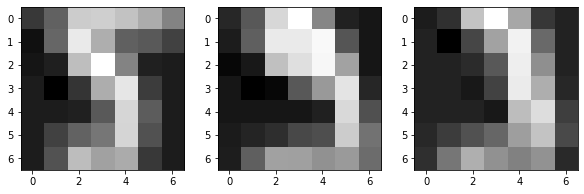

In [32]:
conv_learn = model.conv.weight.detach().numpy()[0][0]
plot_images([convolve(x_test[0],conv_learn),convolve(x_test[1],conv_learn),convolve(x_test[2],conv_learn)], num=3)

También podemos ver qué tipo de representaciones aprende la red después de pasar por las convoluciones.

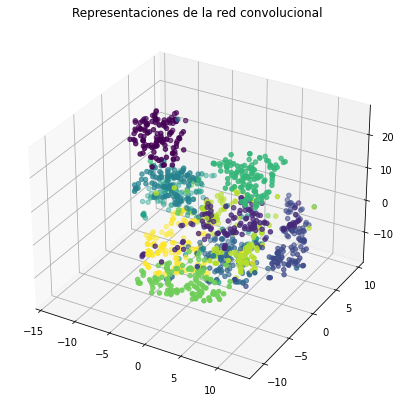

In [33]:
#Aplicación del modelo
model(x_input)
#Reducción de dimensionalidad
h = TSNE(3).fit_transform(model.h.detach().numpy())

#Ploteo
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(h[:,0], h[:,1], h[:,2], c=y_train)
plt.title('Representaciones de la red convolucional')
plt.show()